# Introduction
We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Cen‐
sus Bureau. Each image is labeled with the digit it represents. This set has been stud‐
ied so much that it is often called the “Hello World” of Machine Learning: whenever
people come up with a new classification algorithm, they are curious to see how it
will perform on MNIST. Whenever someone learns Machine Learning, sooner or
later they tackle MNIST.

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier

In [6]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [7]:
X, y = mnist["data"], mnist["target"]
print("Features:", X.shape)
print("Target:", y.shape)

Features: (70000, 784)
Target: (70000,)


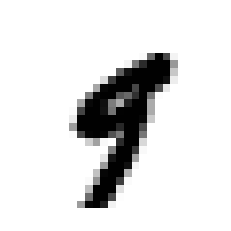

In [11]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [22]:
'''The above one looks like 9, lets verify'''
print(y[36000])

<class 'str'>


In [14]:
'''
The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)
'''
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
'''
Let’s also shuffle the training set. 
This will guarantee that all cross-validation folds will be similar'''
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [23]:
'''Training a Binary Classifier for one digit only 5'''
y_train_5 = (int(y_train) == 5)
y_test_5 = (int(y_test) == 5)
y_train_5

TypeError: only size-1 arrays can be converted to Python scalars

In [19]:
'''Start with SGDClassifier'''
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

ValueError: The number of classes has to be greater than one; got 1 class